# Alanyze data using behavioral model
There are 3 models with different parameter combinations:

1. <b>The Bayesian model (Schwöbel et al. 2021):</b> \
   <b>a.</b> With 3 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, and a decision temparature $\beta$. \
   <b>b.</b> With 4 parameters: a policy forgetting rate $\lambda_{\pi}$, a reward forgetting rate $\lambda_{r}$, a decision temparature $\beta$, and a habitual tendency $h$.
2. <b>A newer MF/MB version that is better for fitting (Otto et al. 2013):</b> \
<b>Note:</b> This is not quite the original version, as the Q-values in the original work did not converge to the true expected values. Instead, I implemented a "bug-fixed" version.\
   <b>a.</b> With 4 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a MF weight parameter $\beta_{MF}$, a MB weight parameter $\beta_{MB}$, a learning rate $\alpha$, and a dicount factor $\lambda$$, and a repetition/perserveration parameter $p$. \
3. <b>The original model-free/model-based (MF/MB) model (Daw et al. 2005, 2011):</b> \
   <b>a.</b> With 4 parameters: a weighting parameters $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, and a dicount factor $\lambda$. \
   <b>b.</b> With 5 parameters: a weighting parameter $\omega$, a decision temperature $\beta$, a learning rate $\alpha$, a dicount factor $\lambda$, and a repetition/perserveration parameter $p$.

Tell python that the code in the submodule is code that we want to import and run

In [1]:
import sys
import os
current_dir = os.path.abspath('')
os.chdir(current_dir)
sys.path.append(os.path.join(current_dir,'..','code','BalancingControl'))

import two_stage_utils as tu
import inference as inf
import inference_utils as iu

torch threads 1
Running on device cpu
torch threads 1


Other imports that we need for simulation, inference, and plotting

In [2]:
import torch
import pyro

import os
from scipy.io import loadmat
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import glob
import jsonpickle as pickle
import json
import gc

Where second stage random walks from the experiment are stored

In [3]:
Rho_data_fname = os.path.join("experiment", "dawrandomwalks.mat")

Define where results should be saved

In [4]:
results_folder = "results"
inference_folder = os.path.join(results_folder, "inference")

In [5]:
processed_data_folder = "processed_data"

full_data_fname = "full_data.csv"
full_data_file = os.path.join(processed_data_folder, full_data_fname)

full_data_df = pd.read_csv(full_data_file)

In [6]:
# number of simulated agents/participants
n_agents = int(full_data_df['subject'].max()+1)
print(n_agents)

print(full_data_df.keys())

188
Index(['Unnamed: 0', 'first_stage_actions', 'second_stage_actions',
       'first_stage_rewards', 'second_stage_rewards', 'first_stage_states',
       'second_stage_states', 'miniblock_index', 'step_index',
       'common_transition', 'mask', 'repeated_actions', 'rewarded', 'subject'],
      dtype='object')


In [7]:
def convert_data_for_agent(full_data_df):

    mask = full_data_df.loc[(full_data_df["step_index"]==1)]
    mask_formatted = torch.stack([torch.from_numpy(mask.loc[mask["subject"]==i]["mask"].to_numpy()) for i in range(n_agents)])

    actions1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    actions1_formatted = torch.stack([torch.from_numpy(actions1.loc[actions1["subject"]==i]["first_stage_actions"].to_numpy()) for i in range(n_agents)])

    actions2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    actions2_formatted = torch.stack([torch.from_numpy(actions2.loc[actions2["subject"]==i]["second_stage_actions"].to_numpy()) for i in range(n_agents)])

    print("possible actions1", torch.unique(actions1_formatted[mask_formatted]))
    print("possible actions2", torch.unique(actions2_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    actions1_formatted = torch.where(mask_formatted, actions1_formatted, -1)
    actions2_formatted = torch.where(mask_formatted, actions2_formatted, -1)

    actions = torch.stack([actions1_formatted, actions2_formatted], dim=-1).permute((1,2,0))
    #print(actions.permute((0,2,1))[mask_formatted])
    # agent counts from zero:
    actions = actions-1.

    states1 = full_data_df.loc[(full_data_df["step_index"]==1)]
    # agent counts from zero, hence -1 at the end:
    states1_formatted = torch.stack([torch.from_numpy(states1.loc[states1["subject"]==i]["first_stage_states"].to_numpy()) for i in range(n_agents)]) - 1
     
    states2 = full_data_df.loc[(full_data_df["step_index"]==2)]
    # agent counts from zero, hence -1 at the end:
    states2_formatted = torch.stack([torch.from_numpy(states2.loc[states2["subject"]==i]["second_stage_states"].to_numpy()) for i in range(n_agents)]) - 1

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    states1_formatted = torch.where(mask_formatted, states1_formatted, -1)
    states2_formatted = torch.where(mask_formatted, states2_formatted, -1)
    # create third time step states:
    states3_formatted = states2_formatted+2 + (actions2_formatted-1)*2
    states3_formatted = torch.where(mask_formatted, states3_formatted, -1)


    print("possible states1", torch.unique(states1_formatted[mask_formatted]))
    print("possible states2", torch.unique(states2_formatted[mask_formatted]))
    print("possible states3", torch.unique(states3_formatted[mask_formatted]))

    states = torch.stack([states1_formatted, states2_formatted, states3_formatted], dim=-1).permute((1,2,0))

    # agent views r=2 as "no reward", may instead give negative reward as in Otto et al:
    rewards1_formatted = torch.zeros_like(states1_formatted) #+ 2

    rewards2_formatted = rewards1_formatted

    # create third time step rewards = second stage rewards:
    rewards3 = full_data_df.loc[(full_data_df["step_index"]==2)]
    rewards3_formatted = torch.stack([torch.from_numpy(rewards3.loc[rewards3["subject"]==i]["second_stage_rewards"].to_numpy()) for i in range(n_agents)])

    print("possible rewards1", torch.unique(rewards1_formatted[mask_formatted]))
    print("possible rewards2", torch.unique(rewards2_formatted[mask_formatted]))
    print("possible rewards3", torch.unique(rewards3_formatted[mask_formatted]))

    # write minus one into invalid regions (currently returns integer overflow below when converted to int)
    rewards1_formatted = torch.where(mask_formatted, rewards1_formatted, -1)
    rewards2_formatted = torch.where(mask_formatted, rewards2_formatted, -1)
    rewards3_formatted = torch.where(mask_formatted, rewards3_formatted, -1)

    rewards = torch.stack([rewards1_formatted, rewards2_formatted, rewards3_formatted], dim=-1).permute((1,2,0))


    data_dict = {"observations": states.long(), "rewards": rewards.long(), "actions": actions.long(), "valid": mask_formatted.permute((1,0))}

    return data_dict

data = convert_data_for_agent(full_data_df)

print(data)

possible actions1 tensor([1., 2.], dtype=torch.float64)
possible actions2 tensor([1., 2.], dtype=torch.float64)
possible states1 tensor([0.], dtype=torch.float64)
possible states2 tensor([1., 2.], dtype=torch.float64)
possible states3 tensor([3., 4., 5., 6.], dtype=torch.float64)
possible rewards1 tensor([0.], dtype=torch.float64)
possible rewards2 tensor([0.], dtype=torch.float64)
possible rewards3 tensor([0., 1.], dtype=torch.float64)
{'observations': tensor([[[ 0,  0,  0,  ..., -1,  0, -1],
         [ 1,  1,  2,  ..., -1,  1, -1],
         [ 3,  3,  4,  ..., -1,  5, -1]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 1,  1,  2,  ...,  1,  1,  2],
         [ 5,  3,  6,  ...,  3,  3,  4]],

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 1,  1,  2,  ...,  2,  2,  1],
         [ 5,  3,  6,  ...,  6,  6,  3]],

        ...,

        [[ 0,  0,  0,  ...,  0,  0,  0],
         [ 1,  1,  2,  ...,  1,  2,  1],
         [ 3,  5,  4,  ...,  3,  6,  3]],

        [[ 0,  0, -1,  ..., 

In [8]:
#print(full_data["observations"][:10,:,50])

#print(full_data["actions"][:10,:,50])

#print(full_data["rewards"][:10,:,50])

#### Global experiment parameters

In [9]:
# number of simulated agents/participants
#n_agents = int(full_data_df['subject'].max()+1)
#n_agents = 15
#print(n_agents)

#start_ind = 30
#end_ind = start_ind + n_agents

#data_small = {"observations": full_data["observations"][...,start_ind:end_ind], "rewards": full_data["rewards"][...,start_ind:end_ind], "actions": full_data["actions"][...,start_ind:end_ind], "valid": full_data["valid"][...,start_ind:end_ind]}

#data = data_small

#print(data["rewards"].shape)

In [10]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# prob for invalid answer (e.g. no reply). Same frequency as in the real data
p_invalid = 1.-1./201.

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward, "p_invalid": p_invalid}

Define states and transition matrices

In [11]:
#generating probability of observations in each state / unity matrix
A = torch.eye(no)


#state transition generative probability (matrix)
B = torch.zeros((ns, ns, na))
b1 = 0.7
nb1 = 1.-b1
b2 = 0.7
nb2 = 1.-b2

B[:,:,0] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [ b1,  0,  0,  0,  0,  0,  0,],
                         [nb1,  0,  0,  0,  0,  0,  0,],
                         [  0,  1,  0,  1,  0,  0,  0,],
                         [  0,  0,  1,  0,  1,  0,  0,],
                         [  0,  0,  0,  0,  0,  1,  0,],
                         [  0,  0,  0,  0,  0,  0,  1,],])

B[:,:,1] = torch.tensor([[  0,  0,  0,  0,  0,  0,  0,],
                         [nb2,  0,  0,  0,  0,  0,  0,],
                         [ b2,  0,  0,  0,  0,  0,  0,],
                         [  0,  0,  0,  1,  0,  0,  0,],
                         [  0,  0,  0,  0,  1,  0,  0,],
                         [  0,  1,  0,  0,  0,  1,  0,],
                         [  0,  0,  1,  0,  0,  0,  1,],])

# add to parameter dict
global_experiment_parameters["A"] = A
global_experiment_parameters["B"] = B

Load and plot reward probabilities

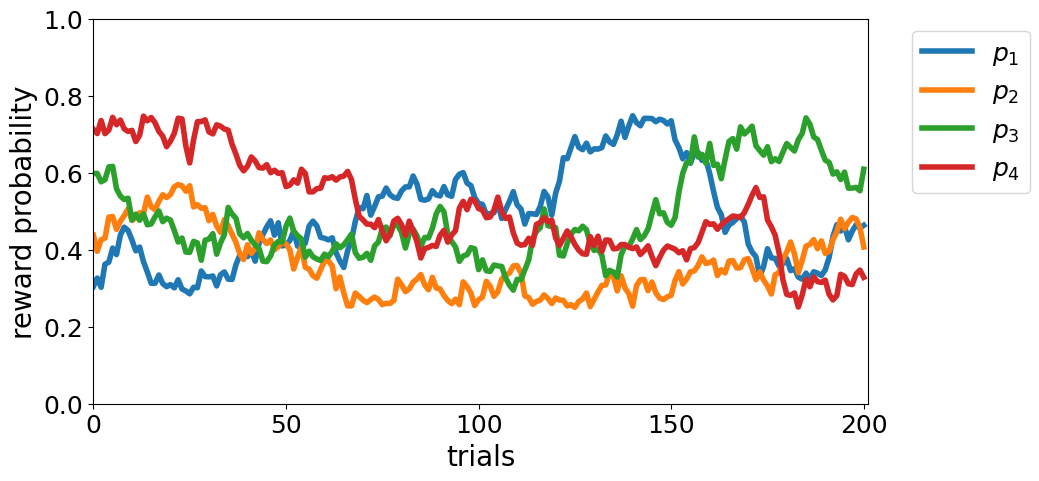

In [12]:
rew_probs = loadmat(Rho_data_fname)['dawrandomwalks']
assert trials==rew_probs.shape[-1]

Rho = torch.zeros((trials, nr, ns))

Rho[:,1,:never_reward] = 0.
Rho[:,0,:never_reward] = 1.

Rho[:,1,never_reward:never_reward+2] = torch.from_numpy(rew_probs[0,:,:]).permute((1,0))
Rho[:,0,never_reward:never_reward+2] = torch.from_numpy(1-rew_probs[0,:,:]).permute((1,0))

Rho[:,1,never_reward+2:] = torch.from_numpy(rew_probs[1,:,:]).permute((1,0))
Rho[:,0,never_reward+2:] = torch.from_numpy(1-rew_probs[1,:,:]).permute((1,0))

plt.figure(figsize=(10,5))
for i in range(4):
    plt.plot(Rho[:,1,3+i], label="$p_{}$".format(i+1), linewidth=4)
plt.ylim([0,1])
plt.yticks(torch.arange(0,1.1,0.2),fontsize=18)
plt.ylabel("reward probability", fontsize=20)
plt.xlim([-0.1, trials+0.1])
plt.xticks(range(0,trials+1,50),fontsize=18)
plt.xlabel("trials", fontsize=20)
plt.legend(fontsize=18, bbox_to_anchor=(1.04,1))
#plt.savefig(os.path.join(results_folder, "twostep_prob.svg"),dpi=300)
plt.show()

# add to parameter dict
global_experiment_parameters["Rho"] = Rho

Now we can start :) 

### 1. BCC:
### 1.a 3 parameter version

Simulation pre-setup

In [13]:
# set parameters and their names

learn_rewards = True
learn_habit = False
use_h = False
learn_cached = False

param_names = []
param_ranges = []

prefix = "BCC"
model_name = "Bayesian prior-based contextual control model"
n_pars = 0
agnt_str = ""

if learn_rewards:
    n_pars += 2
    param_names += ["dec temp", "reward rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_plan"

if learn_habit:
    # infer_h = True
    # infer_policy_rate = True 
    n_pars += 2
    agnt_str += "_habit"
    param_names += ["habitual tendency", "policy rate"]
    if use_h:
        agnt_str += "_h"
        param_ranges += [[0,1], [0,1]]
    else:
        agnt_str += "_weight"
        param_ranges += [[0,8], [0,1]]
# else:
#     infer_h = False
#     infer_policy_rate = False

if learn_cached:
    n_pars += 2
    param_names += ["cached weight", "cached rate"]
    param_ranges += [[0,8], [0,1]]
    agnt_str += "_cached"

assert n_pars > 0, "please turn any part of the agent on, it cannot run without any learning or inference."

# choose max decision temperature for numerical stability
max_dt = 6

# prepare for saving results
# make base filename and folder string
agent_type = prefix+"_"+str(n_pars)+"pars"+agnt_str+"_NO_context"
print(agent_type)

BCC_2pars_plan_NO_context


#### Inference

Inference pre-setup

In [14]:
# prepare for saving results
# make base filename and folder string
fname_base = agent_type+"_inference_"
print(fname_base)
# define folder where we want to save data
base_dir = os.path.join(inference_folder,fname_base[:-1])

# make directory if it doesnt exist
if fname_base[:-1] not in os.listdir(inference_folder):
    os.mkdir(base_dir)

# how many inference steps
num_steps = 600

BCC_2pars_plan_NO_context_inference_


<b>Decide</b> for running or loading inference

In [15]:
run_inference = True

<b>Either:</b> Set up agent and inference. Run main inference loop, plot intermediate and end results

In [16]:
if run_inference:

    # remove old inference?
    remove_old = False

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, data["valid"], remove_old=remove_old)

    print('analyzing '+str(n_agents)+' data sets')

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    num_particles = 15


    print("this is inference using", type(inferrer))
    
    size_chunk = 100
    total_num_iter_so_far = 0

    for i in range(total_num_iter_so_far, num_steps, size_chunk):
        print('taking steps '+str(i+1)+' to '+str(i+size_chunk)+' out of total '+str(num_steps))

        fname_str = fname_base + str(total_num_iter_so_far+size_chunk)+'_'+str(n_agents)+'agents'

        iu.infer(inferrer, size_chunk, fname_str, num_particles, base_dir)
        total_num_iter_so_far += size_chunk

        inferrer.save_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

        inferrer.save_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

        mean_df, sample_df, locs_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir) 

        param_ranges = [[-0.25,1.25], [-0.25,1.25], [0,10]]

        plt.figure()
        vars_of_interest = ["inferred "+name for name in param_names]
        f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,# hue="subject",
                            plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                            grid_kws={"layout_pad": 1.5},
                            x_vars=vars_of_interest, y_vars=vars_of_interest)
        f.map(tu.annot_corrfunc)
        for p, p_range in enumerate(param_ranges):
            f.axes[2,p].set_xlim(p_range)
            f.axes[p,0].set_ylim(p_range)
        #f.axes[2,0].set_ylim(param_ranges[0])
        #f.axes[1,0].set_ylim(param_ranges[1])
        #f.axes[2,0].set_ylim(param_ranges[2])
        plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
        plt.show()

    # sample from posterior only at last time step and save results. Could be done at every step, if earlier posteriors are of interest, one can load the inferrer save and sample from that.
    mean_df, sample_df, locs_df = tu.sample_posterior(inferrer, param_names, fname_str, base_dir) 

/home/sarah/src/TwoStageStrategies/Chen_et_al_data/../code/BalancingControl/perception.py:136: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch-select_1707782759820/work/aten/src/ATen/native/TensorShape.cpp:3637.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


2
analyzing 188 data sets
this is inference using <class 'inference.GeneralGroupInference'>
taking steps 1 to 100 out of total 600


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:11<?, ?it/s]


KeyboardInterrupt: 

<b>Or:</b> Set up agent and inference. Load past inference, decide whether to resample posterior or used stored samples

analyzing 188 data sets


/home/sarah/src/BayesianTwoStageTaskAnalysis/code/BalancingControl/perception.py:107: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1699116133598/work/aten/src/ATen/native/TensorShape.cpp:3571.)
  self.big_trans_matrix = ar.stack([ar.stack([generative_model_states[:,:,policies[pi,t]] for pi in range(self.npi)]) for t in range(self.T-1)]).T.to(device)


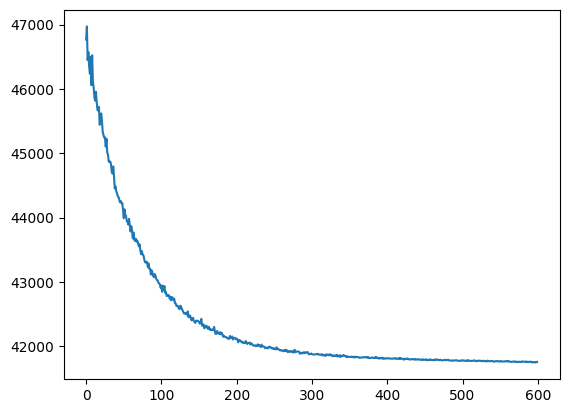

last ELBO: tensor(41754.1641)


In [ ]:
if not run_inference:

    # set up agent
    bayes_agent = tu.set_up_Bayesian_inference_agent(n_agents, learn_rewards, learn_habit, learn_cached, base_dir, global_experiment_parameters, data["valid"], remove_old=False)

    print('analyzing '+str(n_agents)+' data sets')

    resample = True

    # set up inference
    inferrer = inf.GeneralGroupInference(bayes_agent, data)

    fname_str = fname_base + str(num_steps)+'_'+str(n_agents)+'agents'

    inferrer.load_parameters(os.path.join(base_dir, fname_str+"_parameter.save"))

    inferrer.load_elbo(os.path.join(base_dir, fname_str+"_elbo.save"))

    if resample:
        mean_df, sample_df, locs_df = iu.sample_posterior(inferrer, param_names, fname_str, base_dir) 
    else:
        mean_df, sample_df, locs_df = iu.load_samples(base_dir, fname_str) 

plt.figure()
plt.plot(inferrer.loss)
plt.show()

print("last ELBO:", inferrer.loss[-1])

<Figure size 640x480 with 0 Axes>

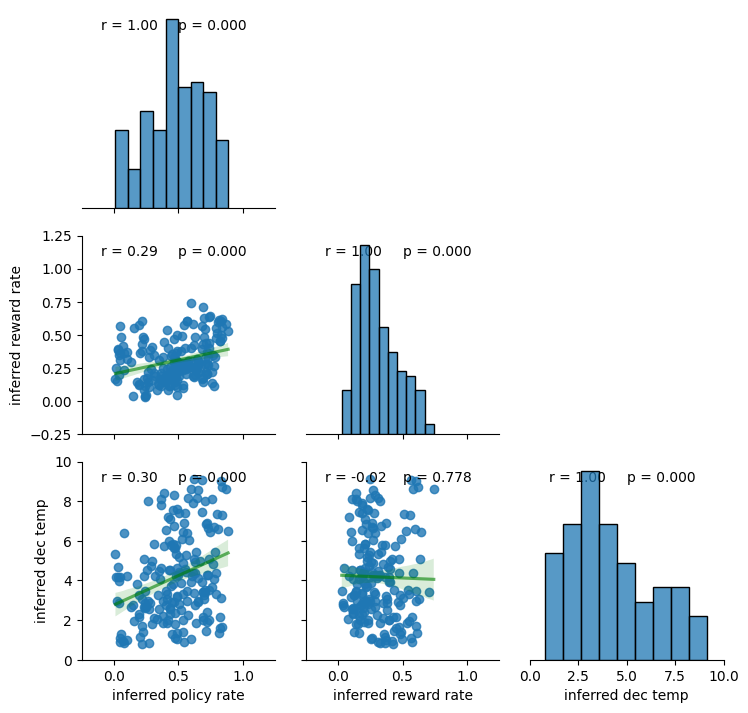

This is inference for the twostage task using the Bayesian prior-based contextual control model(BCC2_3param) with 188 agents.
The settings are: infer h False


In [ ]:
plt.figure()
vars_of_interest = ["inferred "+name for name in param_names]
f = sns.pairplot(data=mean_df, kind='reg', diag_kind="hist", corner=True,
                    plot_kws={'line_kws': {'color': 'green', 'alpha': 0.6}},
                    grid_kws={"layout_pad": 1.5},
                    x_vars=vars_of_interest, y_vars=vars_of_interest)
f.map(tu.annot_corrfunc)
for p, p_range in enumerate(param_ranges):
    f.axes[2,p].set_xlim(p_range)
    f.axes[p,0].set_ylim(p_range)
plt.savefig(os.path.join(base_dir, fname_str+"_pairplot_means_inferred_corr.svg"))
plt.show()
        
print("This is inference for the twostage task using the "+model_name+"("+agent_type+")"+" with "+str(n_agents)+" agents.")